In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Meas = Base.classes.measurement
Sta = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# This is an alternate way to see table names
inspector = inspect(engine)
tables = inspector.get_table_names()
print(tables)

['measurement', 'station']


In [11]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# take a look at a sample of data in measurement table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
# take a look at a sample of data in station table
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Filter between 2016-08-23 and 2017-08-23
date = session.query(Meas.date).order_by(desc(Meas.date)).first()[0]
prev_year = dt.datetime.strptime(date , '%Y-%m-%d') - dt.timedelta(days=365)
prev_year

# Perform a query to retrieve the data and precipitation scores
rain = session.query(Meas.date, Meas.prcp).\
    filter(Meas.date > prev_year).\
    order_by(Meas.date).all()

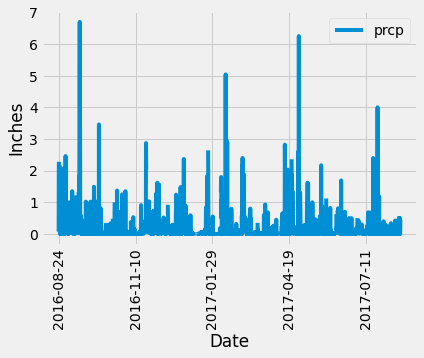

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain,columns = ['date','prcp'])

# Sort the dataframe by date
sort_rain_df = rain_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

sort_rain_df.plot(x='date', y='prcp', rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.savefig('Rain in Hawaii 2016-2017 season - homework')

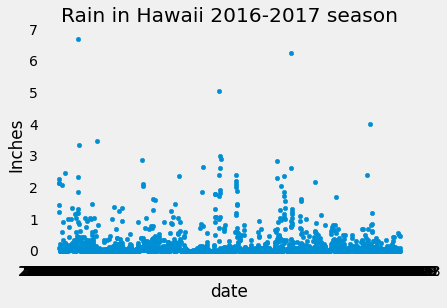

In [17]:
# Note to grader - disregard this step
# This is here for my exploration

sort_rain_df.plot.scatter(x='date', y='prcp',grid = False)
plt.title('Rain in Hawaii 2016-2017 season')
plt.ylabel('Inches')
plt.savefig('Rain in Hawaii 2016-2017 season')

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sort_rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Sta.station)).all()

[(9)]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
rank_stations = session.query(Meas.station, func.count(Meas.station)).\
    group_by(Meas.station).order_by(func.count(Meas.station).desc()).all()
rank_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# grab the first item from ranked stations
most_active = rank_stations[0]
most_active_st = most_active[0]
most_active_st

'USC00519281'

### Note to grader:
###### The output example did not show the station or name;  I added it in this next query for my edification. Homework example follows after

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station_stat = session.query(Meas.station, Sta.name, func.min(Meas.tobs), func.max(Meas.tobs), func.avg(Meas.tobs)).\
    filter(Meas.station == most_active_st).all()
top_station_stat

[('USC00519281', 'WAIKIKI 717.2, HI US', 54.0, 85.0, 71.66378066378067)]

In [23]:
# Add pandas dataframe for practice
top_df = pd.DataFrame(top_station_stat, columns = ["station","station name","min temp","max temp", "avg daily temp"])
top_df

,station,station name,min temp,max temp,avg daily temp
0,USC00519281,"WAIKIKI 717.2, HI US",54.0,85.0,71.663781


### Note to grader:
###### This is more like the output example

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station_stat_hw = session.query(func.min(Meas.tobs), func.max(Meas.tobs), func.avg(Meas.tobs)).\
    filter(Meas.station == most_active_st).all()
top_station_stat_hw

[(54.0, 85.0, 71.66378066378067)]

In [25]:
# Add pandas dataframe for practice
top_df_hw = pd.DataFrame(top_station_stat_hw, columns = ["min temp","max temp", "avg daily temp"])
top_df_hw

,min temp,max temp,avg daily temp
0,54.0,85.0,71.663781


Text(0.5, -1.340000000000014, 'Temperature')

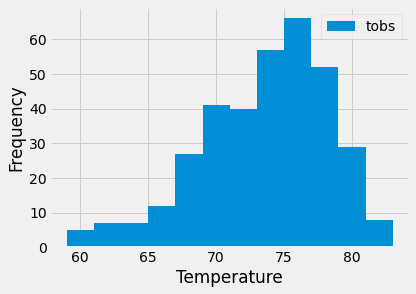

In [26]:
# Choose the station with the highest number of temperature observations. 
# That was calculated before ansd set = most_active_st
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data = session.query(Meas.tobs).\
    filter(Meas.station == most_active_st).\
    filter(Meas.date >= prev_year).all()
temp_data_df = pd.DataFrame(temp_data, columns=['tobs'])
temp_data_df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")


In [27]:
#close the session
session.close()

## Bonus Challenge Assignment

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Meas.tobs), func.avg(Meas.tobs), func.max(Meas.tobs)).\
        filter(Meas.date >= start_date).filter(Meas.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates  
#  I will go for a month in June - we know max date was 2017-08-23 so will use june 2017
start_date = '2017-06-01'
return_date = '2017-06-30'
bonus = calc_temps(start_date, return_date)
bonus

[(71.0, 77.21989528795811, 83.0)]

In [30]:
# create pandas dataframe to help me keep terack
june_df = pd.DataFrame(bonus, columns = ["min temp","avg temp", "max temp"])
june_df

,min temp,avg temp,max temp
0,71.0,77.219895,83.0


In [31]:
temp_list = bonus[0]
temp_min = temp_list[0]
temp_avg = temp_list[1]
temp_max= temp_list[2]

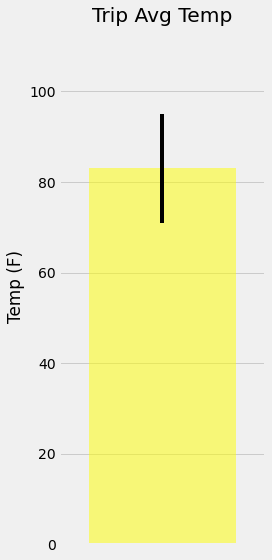

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = temp_max-temp_min

bar = ax.bar(xpos, temp_max, yerr=yerr, alpha=0.5, color='yellow', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)

fig.tight_layout()

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-06-01'
return_date = '2017-06-30'

trip_rainfall = [Sta.station, Sta.name, Sta.latitude, 
       Sta.longitude, Sta.elevation, func.sum(Meas.prcp)]

station_rainfall = session.query(*trip_rainfall).\
    filter(Meas.station == Sta.station).\
    filter(Meas.date >= start_date).\
    filter(Meas.date <= return_date).\
    group_by(Sta.name).order_by(func.sum(Meas.prcp).desc()).all()
print(station_rainfall)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 9.299999999999997), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 4.26), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.9799999999999995), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.6), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.8900000000000001), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.37000000000000005), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.12)]


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Meas.tobs), func.avg(Meas.tobs), func.max(Meas.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Meas.date) == date).all()
    
daily_normals("06-01")


[(64.0, 74.6140350877193, 81.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-06-01'
return_date = '2017-06-30'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, return_date, freq='D')

# Stip off the year and save a list of %m-%d strings
month_day_range = date_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for days in month_day_range:
    normals.append(*daily_normals(days))
    
normals

[(64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0),
 (69.0, 76.01960784313725, 84.0),
 (66.0, 75.66666666666667, 83.0),
 (68.0, 75.66666666666667, 81.0),
 (69.0, 75.62711864406779, 81.0),
 (67.0, 75.40350877192982, 81.0),
 (69.0, 75.41379310344827, 81.0),
 (68.0, 74.59322033898304, 81.0),
 (69.0, 74.60344827586206, 80.0),
 (70.0, 75.44067796610169, 82.0),
 (68.0, 73.96491228070175, 85.0),
 (68.0, 74.75862068965517, 82.0),
 (69.0, 75.15789473684211, 81.0),
 (68.0, 74.54385964912281, 80.0),
 (68.0, 74.96428571428571, 84.0),
 (68.0, 74.10344827586206, 80.0),
 (67.0, 74.21428571428571, 82.0),
 (66.0, 75.01785714285714, 81.0),
 (69.0, 74.88679245283019, 80.0),
 (67.0, 74.91525423728814, 80.0),
 (67.0, 75.59615384615384, 8

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_temps_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_normals_temps_df['date'] = date_range
trip_normals_temps_df.set_index(['date'],inplace=True)
trip_normals_temps_df.head()

,tmin,tavg,tmax
date,,,
2017-06-01,64.0,74.614035,81.0
2017-06-02,65.0,74.400000,81.0
2017-06-03,65.0,74.034483,80.0
2017-06-04,65.0,73.818182,81.0
2017-06-05,68.0,74.854545,81.0


Text(9.310000000000002, 0.5, 'Temperature')

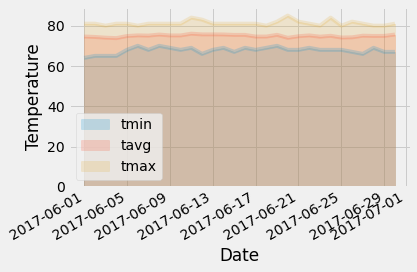

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals_temps_df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature")

In [38]:
session.close()